### Final EWMACD Method

In [1]:
# globals (dev)
FOLDER_MODULES = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\modules'  
FOLDER_SHARED = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\shared'
GRP_LYR_FILE = r"C:\Users\Lewis\Documents\GitHub\tenement-tools\arc\lyr\group_template.lyrx"

# set gdal global environ
import os
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS '] = 'tif'
os.environ['VSI_CACHE '] = 'TRUE'
os.environ['GDAL_HTTP_MULTIRANGE '] = 'YES'
os.environ['GDAL_HTTP_MERGE_CONSECUTIVE_RANGES '] = 'YES'

# also set rasterio env variables
rasterio_env = {
    'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR',
    'CPL_VSIL_CURL_ALLOWED_EXTENSIONS':'tif',
    'VSI_CACHE': True,
    'GDAL_HTTP_MULTIRANGE': 'YES',
    'GDAL_HTTP_MERGE_CONSECUTIVE_RANGES': 'YES'
}

# safe imports
import sys                      # arcgis comes with these
import shutil                   # arcgis comes with these
import datetime                 # arcgis comes with these
import numpy as np              # arcgis comes with these
import arcpy                    # arcgis comes with these
import tempfile                 # arcgis comes with these
from datetime import datetime   # arcgis comes with these

# risky imports (not native to arcgis)
try:
    import xarray as xr
    import dask
    import rasterio
    import pystac_client
    import osr
    import json
    from odc import stac
    from osgeo import gdal
    from osgeo import ogr
    from osgeo import osr
except:
    arcpy.AddError('Python libraries xarray, dask, rasterio, pystac, or odc not installed.')
    raise # return

# import tools
try:
    # shared folder
    sys.path.append(FOLDER_SHARED)
    import arc, satfetcher, tools

    # module folder
    sys.path.append(FOLDER_MODULES)
    import nrt, cog_odc, cog
except:
    arcpy.AddError('Could not find tenement tools python scripts (modules, shared).')
    raise
    
# disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=dask.array.core.PerformanceWarning)
    
# grab parameter values 
in_feat = r"C:\Users\Lewis\Desktop\nrt_projects\ophthalmia\monitoring_areas.gdb\monitoring_areas"
in_ongoing = False
in_time_interval = 24
#in_email_from = parameters[3].value                # email from 
#in_smtp_server = parameters[4].value               # email smtp server 
#in_smtp_port = parameters[5].value                 # email smtp port 
#in_smtp_username = parameters[6].value             # email smtp username 
#in_smtp_password = parameters[7].value             # email smtp password 


# # # # #
# notify user and set up progress bar
#arcpy.AddMessage('Beginning NRT Monitoring of areas.')
#arcpy.SetProgressor(type='step', 
                    #message='Preparing parameters...',
                    #min_range=0, max_range=20)
        
# set up initial continous monitoring var
continue_monitoring = True

# check if time interval is > 0
#in_time_interval = in_time_interval * 60 * 60
#if in_time_interval <= 0:
    #arcpy.AddError('Time interval must be above 0 hours.')
    #raise


# # # # #
# notify and increment progress bar
#arcpy.SetProgressorLabel('Preparing parameters...')
#arcpy.SetProgressorPosition(1)

# get path to monitoring areas feature
feat_desc = arcpy.Describe(in_feat)
in_feat = os.path.join(feat_desc.path, feat_desc.name)


# # # # #
# notify and increment progress bar
#arcpy.SetProgressorLabel('Validating monitoring areas...')
#arcpy.SetProgressorPosition(2)

# validate monitoring area feature class
if not nrt.validate_monitoring_areas(in_feat):
    arcpy.AddError('Monitoring areas feature is invalid.')
    raise # return

    
# # # # #
# notify and increment progress bar
#arcpy.SetProgressorLabel('Loading monitoring area json data...')
#arcpy.SetProgressorPosition(2)
    
# prepare path to expected json file
in_path = os.path.dirname(in_feat)
in_path = os.path.splitext(in_path)[0]
in_path = os.path.dirname(in_path)
#in_data_path = os.path.join(in_path, 'data.json')
    
    
# # # # #
# notify and increment progress bar
#arcpy.SetProgressorLabel('Loading monitoring area features...')
#arcpy.SetProgressorPosition(2)

# set required fields
fields = ['area_id', 'platform', 's_year', 'e_year', 'index', 'persistence', 
          'rule_1_min_conseqs', 'rule_1_inc_plateaus', 'rule_2_min_stdv', 
          'rule_2_bidirectional', 'rule_3_num_zones', 'ruleset', 'alert', 
          'alert_direction', 'email', 'ignore', 'color', 'global_id', 'SHAPE@']

# get feature count and data
try:
    #feats = arcpy.da.SearchCursor(in_feat, fields)
    feats = []
    with arcpy.da.SearchCursor(in_feat, fields) as cursor:
        for row in cursor:
            feats.append(row)
except:
    arcpy.AddError('Could not open monitoring areas feature.')
    raise # return

In [2]:
from importlib import reload
reload(nrt)

<module 'nrt' from 'C:\\Users\\Lewis\\Documents\\GitHub\\tenement-tools\\modules\\nrt.py'>

In [10]:
# # # # #
# notify and set progress bar to defaukt
#arcpy.SetProgressor(type='default', 
                    #message='Iterating through monitoring areas...')

# begin monitoring process iteration
while continue_monitoring:
    for feat in feats:
        
        # # # # #
        # notify and set progress bar to defaukt
        arcpy.AddMessage('Setting up monitoring for area: {}...'.format(feat[0]))

        # !!!TODO ENSURE NO NULL VALUES IN RULES, ETC
        # check if current feat is valid
        if not nrt.validate_monitoring_area(feat):
            arcpy.AddWarning('Monitoring area is invalid, skipping.'.format(feat[0]))
            raise #continue

            
            
        # # # # #
        # notify 
        arcpy.AddMessage('Fetching new and existing satellite data for monitoring area.')     
        
        # get old dataset if exists, else return none
        in_cube_path = os.path.join(in_path, feat[-2] + '.nc')
        ds_old = nrt.safe_load_nc(in_cube_path)
        
        # check start year same as feat, if no, set old xr to none. handles old when none
        ds_old = nrt.check_xr_start_year(ds_old, feat[2])
        
        
        try:
            # get satellite parameters, bbox from geometry, then lazy load
            params = nrt.get_satellite_params(platform=feat[1])
            bbox = arc.get_bbox_from_geom(in_geom=feat[-1])
            ds_new = nrt.fetch_cube_data(collections=params.get('collections'), 
                                         bands=params.get('bands'), 
                                         start_dt='1980-01-01', 
                                         #end_dt='2050-12-31',  use this when happy 
                                         end_dt='2015-12-31',
                                         bbox=bbox, 
                                         resolution=10, 
                                         ds_existing=None)

        except:
            arcpy.AddWarning('Could not obtain latest satellite data, skipping area.')
            raise # continue
            
            
            
        # # # # #
        # notify 
        arcpy.AddMessage('Reducing satellite data down to only new images.')
                
        # get latest dates from new xr, if no new (or fail), sets to none
        if ds_old is not None:
            ds_new = nrt.extract_new_xr_dates(ds_old, ds_new)
                
        # do quick check if new times were returned
        if ds_new is None:
            arcpy.AddMessage('No new satellite images found, moving to next area.')
            raise #continue
        else:
            arcpy.AddMessage('New satellite images found: {}.'.format(len(ds_new['time'])))
        
                
        
        # # # # #
        # notify 
        arcpy.AddMessage('Cleaning satellite data and calculating vegetation.')
            
        # group duplicate times if exist and rechunk
        ds_new = satfetcher.group_dupe_times(ds_new)
        
        # remove invalid pixels       
        mask_band = arc.get_name_of_mask_band(list(ds_new))
        ds_new = cog.remove_fmask_dates(ds=ds_new, 
                                        valid_class=[1, 4, 5],   # valid, water, snow
                                        max_invalid=0,           # 0% cloud
                                        mask_band=mask_band, 
                                        nodata_value=np.nan,
                                        drop_fmask=True)     

        # conform dea band names and calc vegetation index
        ds_new = satfetcher.conform_dea_ard_band_names(ds=ds_new, platform=feat[1].lower()) 
        ds_new = tools.calculate_indices(ds=ds_new, 
                                         index=feat[4].lower(), 
                                         custom_name='veg_idx', 
                                         rescale=False, 
                                         drop=True)
        
        
        
        # # # # #
        # notify 
        arcpy.AddMessage('Downloading satellite data - hold tight.')
        
        # safe load/download dataset and check output
        ds_new = nrt.safe_load_ds(ds_new)
        if ds_new is None or len(ds_new['time']) == 0 or ds_new.to_array().isnull().all():
            arcpy.AddError('Satellite download returned no data, skipping area.')  
            raise # continue

            
            
        # # # # #
        # notify 
        arcpy.AddMessage('Masking out edge pixels of monitoring area boundary.')

        try:
            # covert arcpy geom to ogr layer for masking via gjson
            gjson = arc.convert_arcpy_geom_to_gjson(arcpy_geom=feat[-1])
            ogr_geom = ogr.Open(gjson, 0)
            lyr = ogr_geom.GetLayer()

            # generate and apply mask
            mask = nrt.mask_xr_via_polygon(ds=ds_new, geom=lyr, mask_value=1)
            ds_new = ds_new.where(mask)
        except:
            arcpy.AddWarning('Could not mask edges, proceeding without mask.')
            raise #pass 
        
        
        
        # # # # #
        # notify 
        arcpy.AddMessage('Preparing old and new satellite data for analysis.')    
        
        # reduce data to temporal means, interp nans, add needed vars
        ds_new = ds_new.sortby('time').mean(['x', 'y'])
        ds_new = nrt.interp_nans(ds_new, drop_edge_nans=True)
        ds_new = nrt.add_required_vars(ds_new)

        # check if anything exists once again...
        if ds_new is None or len(ds_new['time']) == 0 or ds_new.to_array().isnull().all():
            arcpy.AddError('No satellite data exists after clean, skipping area.')  
            raise # continue
            
        # combine old xr with new xr (handles no old data)
        ds_cmb = nrt.combine_old_new_xrs(ds_old, ds_new)
        
        # remove spikes, interp nan, smooth across all time for veg
        ds_cmb['veg_clean'] = nrt.remove_spikes(ds_cmb['veg_idx'], user_factor=1, win_size=3)
        ds_cmb['veg_clean'] = nrt.interp_nans(ds_cmb['veg_clean'], drop_edge_nans=False)
        ds_cmb['veg_clean'] = nrt.smooth_signal(ds_cmb['veg_clean']) 
        
        # make a temp copy for intermediate working
        ds_tmp = ds_cmb.copy(deep=True)

        
        
        # # # # #
        # notify 
        arcpy.AddMessage('Performing change detection.')   
        
        try:  
            # remove any dates prior to training year start
            ds_tmp = ds_tmp.where(ds_tmp['time.year'] >= feat[2], drop=True)
        
            # perform change detection (append to tmp), if ewmacd fails, returns array of nans
            ds_tmp = nrt.detect_change(ds=ds_tmp,
                                       method='both',        # static
                                       var='veg_idx',        # veg_clean performs worse?
                                       train_start=feat[2], 
                                       train_end=feat[3],
                                       persistence=feat[5],
                                       add_to_ds=True)
                        
            # smooth change detection signal. if error occurs, returns original da (prob all nans)
            ds_tmp['static_clean'] = nrt.smooth_signal(ds_tmp['static_raw']) 
            ds_tmp['dynamic_clean'] = nrt.smooth_signal(ds_tmp['dynamic_raw']) 
            
            # check if anything exists once again...
            if ds_tmp['static_clean'].isnull().all() or ds_tmp['dynamic_clean'].isnull().all():
                arcpy.AddError('No change data generated, skipping area.')  
                raise # continue
        except:
            arcpy.AddError('Could not perform change detection, skipping to next area.')
            raise # continue 
                        

            
        # # # # #
        # notify 
        arcpy.AddMessage('Preparing data for rule generation.')    
        
        # transfer all old change vals to tmp, missing new. if no old, no need to transfer
        if ds_old is not None:
            data_vars = ['static_raw', 'static_clean', 'dynamic_raw', 'dynamic_clean']
            ds_tmp = nrt.transfer_xr_values(ds_to=ds_tmp,
                                            ds_from=ds_old,
                                            data_vars=data_vars)

            
            
        # # # # #
        # notify 
        arcpy.AddMessage('Generating ruleset values.')
        
        # figure out what we want exactly from shapefile
        # rule 2 zones instead of raw stdv?
        # rule 2 bidrectional moved to just alert direction?
        # leave until end
                
        
        # put below into single func
        #def generate_all_rules()
        
        # !!!for 2d, may need input_core_dims [['time']] with vectorize=True!!!
        # generate rule 1 runs (all +/-) for static change 1d
        # output is + and - values showing direction (sign) and run count
        ds_tmp['static_rule_one'] = xr.apply_ufunc(nrt.build_rule_one_runs,
                                                   ds_tmp['static_clean'],
                                                   kwargs={'min_conseqs': 3, #feat[6]
                                                           'inc_plateaus': False}) #feat[7]

        # generate rule 1 runs (all +/-) for dynamic change 1d
        # output is + and - values showing direction (sign) and run count
        ds_tmp['dynamic_rule_one'] = xr.apply_ufunc(nrt.build_rule_one_runs,
                                                    ds_tmp['dynamic_clean'],
                                                    kwargs={'min_conseqs': 3, #feat[6]
                                                            'inc_plateaus': False}) #feat[7]
        
        
        # todo change shp file rule_2_mind_stdv to min_zone
        # todo remove rule_2_bidrectional field, use alert direction to do that work?
        # convert 
        
        # generate rule 2 threshold (all +/-) for static change 1d
        # output is + and - values showing stdv value outside exclusion area
        ds_tmp['static_rule_two'] = xr.apply_ufunc(nrt.build_rule_two_mask,
                                                   ds_tmp['static_clean'],
                                                   kwargs={'min_stdv': 2})

        # generate rule 2 threshold (all +/-) for dynamic change 1d
        ds_tmp['dynamic_rule_two'] = xr.apply_ufunc(nrt.build_rule_two_mask,
                                                    ds_tmp['dynamic_clean'],
                                                    kwargs={'min_stdv': 2})
        
        
        # convert nom jumps to stdv
        
        # generate rule 3 spikes (all +/-) for static change 1d
        # output is + and - values showing stdv value outside exclusion area
        ds_tmp['static_rule_three'] = xr.apply_ufunc(nrt.build_rule_three_spikes,
                                                     ds_tmp['static_clean'],
                                                     kwargs={'min_stdv': 3})

        # generate rule 3 spikes (all +/-) for dynamic change 1d
        ds_tmp['dynamic_rule_three'] = xr.apply_ufunc(nrt.build_rule_three_spikes,
                                                      ds_tmp['dynamic_clean'],
                                                      kwargs={'min_stdv': 3})        
        
        
        # alrt dir static or dynamic, but not both. remove from allowed vals
        #
        #
        
        
        try:
            # generate alerts based on rule combinations. error results in nan arrays
            ds_tmp = nrt.build_alerts(ds=ds, ruleset=None, direction=None) # feat[]
        except:
            arcpy.AddError('Could not mask edges, proceeding without mask.')
            raise #continue 
        
        
        

        
        # add attributes to output dataset
        ds_cmb.attrs.update({'s_year': feat[2]})
        
        # TEMP!
        #data_vars = ['static_raw', 'static_clean', 'dynamic_raw', 'dynamic_clean']
        #ds_cmb = nrt.transfer_xr_values(ds_to=ds_cmb,
                                        #ds_from=ds_tmp,
                                        #data_vars=data_vars)
        
        
        #ds_cmb.to_netcdf(in_cube_path)
        #ds_tmp.to_netcdf(in_cube_path)
        
        # update symbology 
        #try:
            # reset symbology (do before insert else error...)
            #p = arcpy.mp.ArcGISProject('CURRENT')
            #m = p.activeMap
            #for layer in m.listLayers('monitoring_areas'):
                #arc.apply_monitoring_area_symbology(layer)
        #except:
            #arcpy.AddWarning('Could not apply symbology to montiroing areas. Skipping.')
        
        raise
        
    raise

File does not exist: C:\Users\Lewis\Desktop\nrt_projects\ophthalmia\44328d6b6b494ff795c0f0765bb57efa.nc, returning None.
Old dataset is none. Returning none.
Obtaining all satellite data for monitoring area.
Beginning STAC search for items. This can take awhile.


ValueError: Error occurred during fetching of stac metadata.

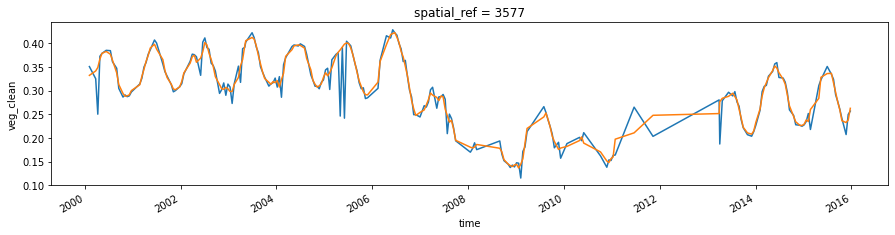

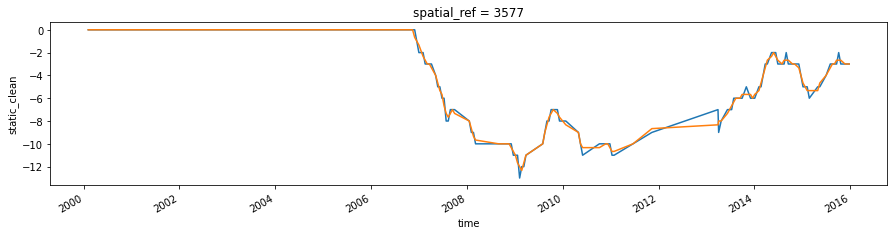

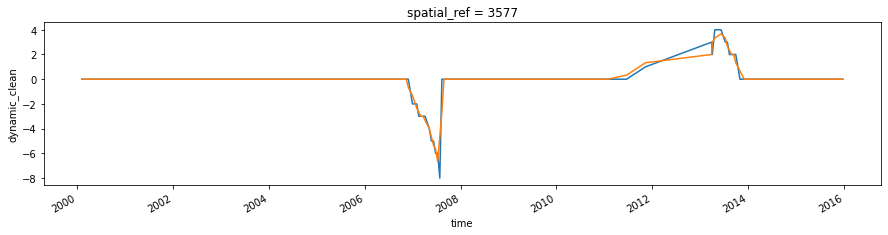

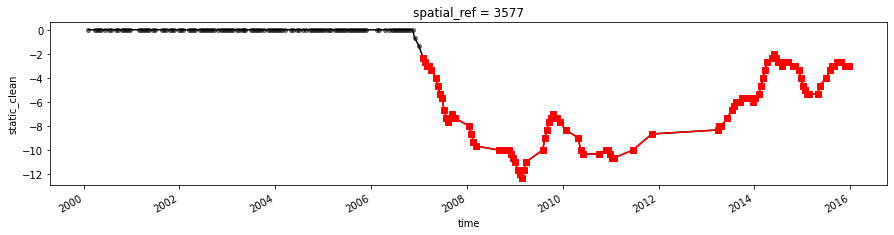

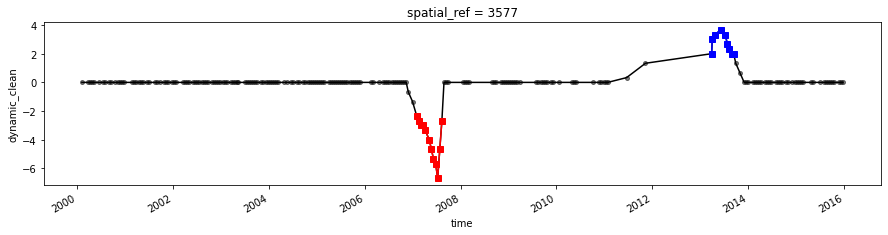

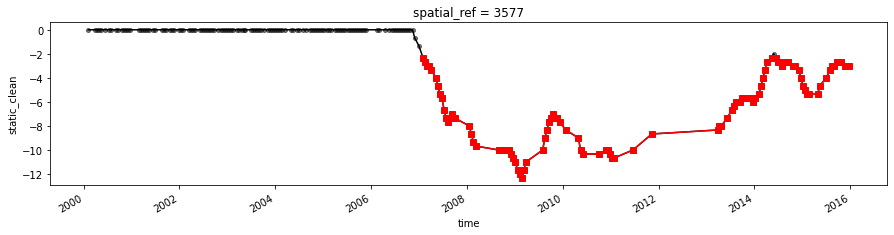

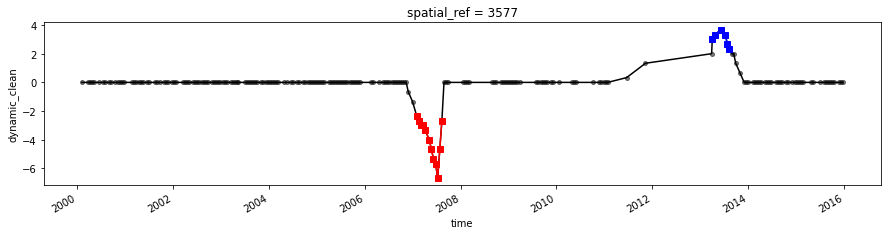

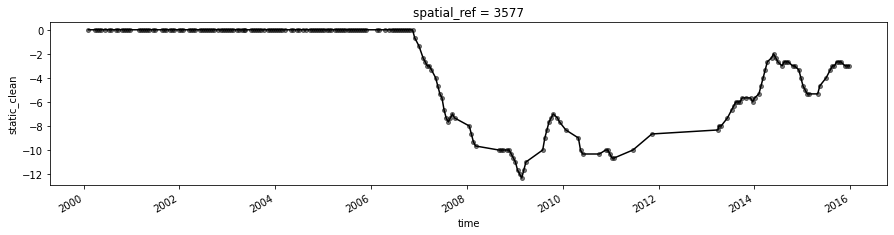

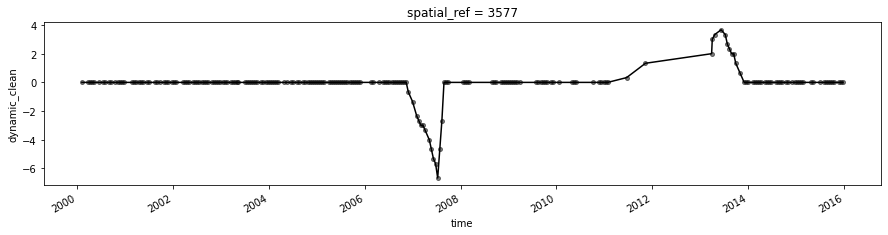

In [183]:
%matplotlib inline
import matplotlib.pyplot as plt

if True:
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['veg_idx'].plot()
    ds_tmp['veg_clean'].plot()
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_raw'].plot()
    ds_tmp['static_clean'].plot()
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_raw'].plot()
    ds_tmp['dynamic_clean'].plot()
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_clean'].plot(color='black')
    ds_tmp['static_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['static_clean'].where(ds_tmp['static_rule_one'] > 0).plot(marker='s', color='blue')
    ds_tmp['static_clean'].where(ds_tmp['static_rule_one'] < 0).plot(marker='s', color='red')
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_clean'].plot(color='black')
    ds_tmp['dynamic_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_one'] > 0).plot(marker='s', color='blue')
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_one'] < 0).plot(marker='s', color='red')
    plt.show()
    
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_clean'].plot(color='black')
    ds_tmp['static_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['static_clean'].where(ds_tmp['static_rule_two'] > 0).plot(marker='s', color='blue')
    ds_tmp['static_clean'].where(ds_tmp['static_rule_two'] < 0).plot(marker='s', color='red')
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_clean'].plot(color='black')
    ds_tmp['dynamic_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_two'] > 0).plot(marker='s', color='blue')
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_two'] < 0).plot(marker='s', color='red')
    plt.show()
    
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_clean'].plot(color='black')
    ds_tmp['static_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['static_clean'].where(ds_tmp['static_rule_three'] > 0).plot(marker='s', color='blue')
    ds_tmp['static_clean'].where(ds_tmp['static_rule_three'] < 0).plot(marker='s', color='red')
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_clean'].plot(color='black')
    ds_tmp['dynamic_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_three'] > 0).plot(marker='s', color='blue')
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_three'] < 0).plot(marker='s', color='red')
    plt.show()

In [50]:
# rule 1 min conseqs
rule_one_consequtives = feat[6]
plats = feat[7]
r2_minstdv = feat[8]
bidir = feat[9]
r3_spike = feat[10]
ruleset = feat[11]

do_alert = feat[12]
#alert_dir = feat[13]

#alert_dir = feat[14]

#ignore = feat[15]

In [ ]:
rule_one_consequtives=3
#rule_two_min_stdv we dont need this
#rule_three_min_stdv = 
alert_direction='Decline'

ds = ds_tmp.copy(deep=True)

In [165]:
ruleset = '1&2|3'
direction = 'Decline'

ds = ds_tmp.copy(deep=True)

In [245]:
ds_tmp

<xarray.Dataset>
Dimensions:             (time: 222)
Coordinates:
    spatial_ref         int32 3577
  * time                (time) datetime64[ns] 2000-02-06T01:49:38 ... 2015-12...
Data variables: (12/16)
    veg_idx             (time) float32 0.3507 0.325 0.2501 ... 0.2495 0.2566
    veg_clean           (time) float32 0.3321 0.3415 0.3487 ... 0.2377 0.2625
    static_raw          (time) float32 0.0 0.0 0.0 0.0 ... -3.0 -3.0 -3.0 -3.0
    static_clean        (time) float32 0.0 0.0 0.0 0.0 ... -2.667 -3.0 -3.0 -3.0
    static_rule_one     (time) float32 0.0 0.0 0.0 0.0 ... -2.667 -3.0 -3.0 -3.0
    static_rule_two     (time) float32 0.0 0.0 0.0 0.0 ... -2.667 -3.0 -3.0 -3.0
    ...                  ...
    dynamic_clean       (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dynamic_rule_one    (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dynamic_rule_two    (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dynamic_rule_three  (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dynamic_zones       (time) float32 nan nan nan nan nan ... nan nan nan nan
    dynamic_alerts      (time) float32 nan nan nan nan nan ... nan nan nan nan

In [252]:
def build_zones(arr):
    """
    takes a smoothed (or raw) ewmacd change detection
    signal and classifies into 1 of 11 zones based on the
    stdv values. this is used to help flag and colour
    outputs for nrt monitoring. Outputs include 
    zone direction information in way of sign (-/+).
    """   

    # set up zone ranges (stdvs)
    zones = [
        [0, 1],    # zone 1 - from 0 to 1 (+/-)
        [1, 3],    # zone 2 - between 1 and 3 (+/-)
        [3, 5],    # zone 3 - between 3 and 5 (+/-)
        [5, 7],    # zone 4 - between 5 and 7 (+/-)
        [7, 9],    # zone 5 - between 7 and 9 (+/-)
        [9, 11],   # zone 6 - between 9 and 11 (+/-)
        [11, 13],  # zone 7 - between 11 and 13 (+/-)
        [13, 15],  # zone 8 - between 13 and 15 (+/-)
        [15, 17],  # zone 9 - between 15 and 17 (+/-)
        [17, 19],  # zone 10 - between 17 and 19 (+/-)
        [19]       # zone 11- above 19 (+/-)
    ]

    # get sign mask
    arr_neg_mask = np.where(arr < 0, True, False)
    
    # create template arr
    arr_temp = np.full_like(arr, np.nan)
    
    # get abs of arr
    arr = np.abs(arr)

    # iter zones
    for i, z in enumerate(zones, start=1):

        if i == 1:
            arr_temp[np.where((arr >= z[0]) & (arr < z[1]))] = i
            #arr_temp[np.where((arr < z[0]) & (arr >= z[1]) * -1)] = i * -1
            
        elif i == 11:
            arr_temp[np.where(arr >= z[0])] = i
            #arr_temp[np.where(arr < z[0] * -1)] = i * -1
            
        else:
            arr_temp[np.where((arr >= z[0]) & (arr < z[1]))] = i
            #arr_temp[np.where((arr < z[0] * -1) & (arr >= z[1] * -1))] = i * -1
        
    # check if arr sizes match
    
    # check if any nan within
    
    # mask signs
    arr_temp = np.where(arr_neg_mask, arr_temp * -1, arr_temp)
    
    
    return arr_temp

In [253]:
build_zones(arr)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1., -2., -2., -2., -3., -3., -3., -3., -3.,
       -4., -4., -4., -5., -5., -5., -5., -5., -5., -5., -6., -6., -6.,
       -6., -6., -6., -6., -6., -6., -7., -7., -7., -7., -7., -7., -6.,
       -6., -5., -5., -5., -5., -5., -5., -5., -6., -6., -6., -6., -6.,
       -6., -6., -6., -6., -6., -5., -5., -5., -5., -5., -4., -4

In [243]:
arr = ds_tmp['static_clean'].values

In [185]:
xr.apply_ufunc(,
               ds['static_clean'])

<xarray.Dataset>
Dimensions:             (time: 222)
Coordinates:
    spatial_ref         int32 3577
  * time                (time) datetime64[ns] 2000-02-06T01:49:38 ... 2015-12...
Data variables: (12/16)
    veg_idx             (time) float32 0.3507 0.325 0.2501 ... 0.2495 0.2566
    veg_clean           (time) float32 0.3321 0.3415 0.3487 ... 0.2377 0.2625
    static_raw          (time) float32 0.0 0.0 0.0 0.0 ... -3.0 -3.0 -3.0 -3.0
    static_clean        (time) float32 0.0 0.0 0.0 0.0 ... -2.667 -3.0 -3.0 -3.0
    static_rule_one     (time) float32 0.0 0.0 0.0 0.0 ... -2.667 -3.0 -3.0 -3.0
    static_rule_two     (time) float32 0.0 0.0 0.0 0.0 ... -2.667 -3.0 -3.0 -3.0
    ...                  ...
    dynamic_clean       (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dynamic_rule_one    (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dynamic_rule_two    (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dynamic_rule_three  (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dynamic_zones       (time) float32 nan nan nan nan nan ... nan nan nan nan
    dynamic_alerts      (time) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0